In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os
import joblib

In [4]:
data = joblib.load("data_with_features.joblib")
data

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd,metabolite_features,protein_features
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12646541, -0.15512069, 0.0834027, 0.213126..."
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509,"[0.4610253, 0.039623156, -0.4662559, 0.4188257...","[-0.10084063, -0.099633686, -0.011382125, 0.10..."
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12705962, -0.09898393, 0.0041820942, 0.096..."
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939,"[0.52348095, -0.18665986, -0.39555183, 0.11716...","[0.0015065962, -0.087554656, -0.014490904, -0...."
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935,"[0.17630623, -0.4595529, -0.6368343, -0.136045...","[0.0015065962, -0.087554656, -0.014490904, -0...."
...,...,...,...,...,...,...,...,...,...,...
17005,1.1.1.82,Zea mays,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,955.0000,s^(-1),2.980003,"[0.36284313, -0.21340896, -0.8913718, -0.23485...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17006,1.1.1.82,Zea mays,C(C(C(=O)O)O)C(=O)O,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17007,1.1.1.82,Zea mays,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.18913552, -0.06542938, -0.8761325, 0.133454...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17008,1.1.1.82,Spinacia oleracea,C(C(C(=O)O)O)C(=O)O,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,6.7000,s^(-1),0.826075,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.029217303, -0.08372673, 0.0883128, 0.147737..."


In [5]:
# adding 1e-9 to prevent error when doing logarithm
# ??????
data["label"] = -np.log10(data["Raw Kd"] + 1e-9)

In [6]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            "metabolite_features": torch.tensor(
                np.asarray(row["metabolite_features"], dtype=np.float32)
            ),
            "protein_features": torch.tensor(
                np.asarray(row["protein_features"], dtype=np.float32)
            ),
            "label": torch.tensor(float(row["label"]), dtype=torch.float32),
        }

In [7]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)
total_dataset = MPI_Dataset(data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
total_loader = DataLoader(total_dataset, batch_size=32, shuffle=False)


In [8]:
import torch.nn as nn
import torch


# Define Diffusion Generative Model for Regression
class DiffusionGenerativeModel(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, hidden_dim, num_timesteps):
        super(DiffusionGenerativeModel, self).__init__()
        self.num_timesteps = num_timesteps
        self.mol_encoder = nn.Linear(mol_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.denoise_model = nn.Linear(hidden_dim * 2, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, 1)  # Regression layer
        self.activation = nn.ReLU()

        # Embedding for timesteps
        self.timestep_embedding = nn.Embedding(num_timesteps, hidden_dim * 2)

    def forward(self, mol_features, protein_features, t):
        # Encode mol and protein features
        mol_embedding = self.activation(self.mol_encoder(mol_features))
        protein_embedding = self.activation(self.protein_encoder(protein_features))

        # Concatenate embeddings
        combined = torch.cat((mol_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Add learnable timestep embedding
        t_embedding = self.timestep_embedding(t.long())
        combined += t_embedding

        # Denoise process
        denoised = self.activation(self.denoise_model(combined))

        # Regression layer
        output = self.regressor(denoised)  # Predict continuous values
        return output

    def add_noise(self, x, noise_level=0.1):
        noise = noise_level * torch.randn_like(x)
        return x + noise

In [9]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr

train_history = pd.DataFrame(
    columns=[
        "epoch",
        "Train Loss",
        "Train MSE",
        "Train MAE",
        "Train RMSE",
        "Train R2",
        "Train Pearson",
        "Train Median_AE",
        "Train Explained_VAR" "Val Loss",
        "Val MSE",
        "Val MAE",
        "Val RMSE",
        "Val R2",
        "Val Pearson",
        "Val Median_AE",
        "Val Explained_VAR",
    ]
)
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch["metabolite_features"].shape[
        1
    ]  # Dynamically determine mol input dimension
    protein_input_dim = batch["protein_features"].shape[
        1
    ]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = DiffusionGenerativeModel(
    mol_input_dim=mol_input_dim,
    protein_input_dim=protein_input_dim,
    hidden_dim=512,
    num_timesteps=num_timesteps,
)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch["metabolite_features"].to(device)
        protein_features = batch["protein_features"].to(device)
        labels = batch["label"].to(device)

        # Add noise to the features
        noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        optimizer.zero_grad()
        outputs = model(
            noisy_mol_features,
            noisy_protein_features,
            torch.randint(0, num_timesteps, (mol_features.size(0),)).to(device),
        ).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = (
        ((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2)
        .mean()
        .item()
    )
    train_mae = (
        torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels))
        .mean()
        .item()
    )
    train_rmse = (
        torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2)
        .mean()
        .item()
    )
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(
        np.array(train_labels), np.array(train_predictions)
    )
    train_median_ae = median_absolute_error(
        np.array(train_labels), np.array(train_predictions)
    )
    train_explained_var = explained_variance_score(
        np.array(train_labels), np.array(train_predictions)
    )

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}"
        )

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch["metabolite_features"].to(device)
            protein_features = batch["protein_features"].to(device)
            labels = batch["label"].to(device)

            # Add noise to the features
            noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
            noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

            outputs = model(
                noisy_mol_features,
                noisy_protein_features,
                torch.randint(0, num_timesteps, (mol_features.size(0),)).to(device),
            ).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = (
        ((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    )
    val_mae = (
        torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels))
        .mean()
        .item()
    )
    val_rmse = (
        torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2)
        .mean()
        .item()
    )
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(
        np.array(val_labels), np.array(val_predictions)
    )
    val_explained_var = explained_variance_score(
        np.array(val_labels), np.array(val_predictions)
    )

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}"
        )

    # Save metrics to DataFrame
    new_row = {
        "epoch": epoch + 1,
        "Train Loss": total_loss / len(train_loader),
        "Train MSE": train_mse,
        "Train MAE": train_mae,
        "Train RMSE": train_rmse,
        "Train R2": train_r2,
        "Train Pearson": train_pearson_corr,
        "Train Median_AE": train_median_ae,
        "Train Explained_VAR": train_explained_var,
        "Val Loss": val_total_loss / len(val_loader),
        "Val MSE": val_mse,
        "Val MAE": val_mae,
        "Val RMSE": val_rmse,
        "Val R2": val_r2,
        "Val Pearson": val_pearson_corr,
        "Val Median_AE": val_median_ae,
        "Val Explained_VAR": val_explained_var,
    }
    train_history = pd.concat(
        [train_history, pd.DataFrame([new_row])], ignore_index=True
    )

# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch["metabolite_features"].to(device)
        protein_features = batch["protein_features"].to(device)
        labels = batch["label"].to(device)

        # Add noise to the features
        noisy_mol_features = model.add_noise(mol_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(
            noisy_mol_features,
            noisy_protein_features,
            torch.randint(0, num_timesteps, (mol_features.size(0),)).to(device),
        ).squeeze()
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = (
    ((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
)
test_mae = (
    torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
)
test_rmse = (
    torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2)
    .mean()
    .item()
)
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(
    np.array(test_labels), np.array(test_predictions)
)
test_explained_var = explained_variance_score(
    np.array(test_labels), np.array(test_predictions)
)
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

Training Epoch 1: 100%|██████████| 373/373 [00:01<00:00, 208.59it/s]
/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_26180/374893312.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Train Loss: 2.1217, Train MSE: 2.1254, Train MAE: 1.1319
Epoch 0 - Validation Loss: 2.0660, Validation MSE: 2.0661, Validation MAE: 1.1228


Training Epoch 11: 100%|██████████| 373/373 [00:01<00:00, 245.78it/s]


Epoch 10 - Train Loss: 1.6441, Train MSE: 1.6401, Train MAE: 0.9899
Epoch 10 - Validation Loss: 1.7595, Validation MSE: 1.7607, Validation MAE: 1.0068


Training Epoch 21: 100%|██████████| 373/373 [00:01<00:00, 244.17it/s]


Epoch 20 - Train Loss: 1.4628, Train MSE: 1.4638, Train MAE: 0.9290
Epoch 20 - Validation Loss: 1.5949, Validation MSE: 1.5956, Validation MAE: 0.9595


Training Epoch 31: 100%|██████████| 373/373 [00:01<00:00, 236.73it/s]


Epoch 30 - Train Loss: 1.3371, Train MSE: 1.3390, Train MAE: 0.8857
Epoch 30 - Validation Loss: 1.5408, Validation MSE: 1.5418, Validation MAE: 0.9270


Training Epoch 41: 100%|██████████| 373/373 [00:01<00:00, 242.15it/s]


Epoch 40 - Train Loss: 1.2660, Train MSE: 1.2602, Train MAE: 0.8584
Epoch 40 - Validation Loss: 1.4863, Validation MSE: 1.4880, Validation MAE: 0.9060


Training Epoch 51: 100%|██████████| 373/373 [00:01<00:00, 237.74it/s]


Epoch 50 - Train Loss: 1.1987, Train MSE: 1.2008, Train MAE: 0.8354
Epoch 50 - Validation Loss: 1.4287, Validation MSE: 1.4319, Validation MAE: 0.8956


Training Epoch 61: 100%|██████████| 373/373 [00:01<00:00, 242.59it/s]


Epoch 60 - Train Loss: 1.1176, Train MSE: 1.1174, Train MAE: 0.8052
Epoch 60 - Validation Loss: 1.4025, Validation MSE: 1.4050, Validation MAE: 0.8901


Training Epoch 71: 100%|██████████| 373/373 [00:01<00:00, 244.61it/s]


Epoch 70 - Train Loss: 1.0711, Train MSE: 1.0682, Train MAE: 0.7862
Epoch 70 - Validation Loss: 1.4054, Validation MSE: 1.4081, Validation MAE: 0.8853


Training Epoch 81: 100%|██████████| 373/373 [00:01<00:00, 244.51it/s]


Epoch 80 - Train Loss: 1.0476, Train MSE: 1.0486, Train MAE: 0.7786
Epoch 80 - Validation Loss: 1.3181, Validation MSE: 1.3209, Validation MAE: 0.8493


Training Epoch 91: 100%|██████████| 373/373 [00:01<00:00, 246.71it/s]


Epoch 90 - Train Loss: 1.0082, Train MSE: 1.0090, Train MAE: 0.7607
Epoch 90 - Validation Loss: 1.3211, Validation MSE: 1.3226, Validation MAE: 0.8561


Training Epoch 101: 100%|██████████| 373/373 [00:01<00:00, 244.54it/s]


Epoch 100 - Train Loss: 0.9608, Train MSE: 0.9625, Train MAE: 0.7435
Epoch 100 - Validation Loss: 1.3243, Validation MSE: 1.3274, Validation MAE: 0.8391


Training Epoch 111: 100%|██████████| 373/373 [00:01<00:00, 245.19it/s]


Epoch 110 - Train Loss: 0.9491, Train MSE: 0.9507, Train MAE: 0.7372
Epoch 110 - Validation Loss: 1.3017, Validation MSE: 1.3045, Validation MAE: 0.8303


Training Epoch 121: 100%|██████████| 373/373 [00:01<00:00, 246.66it/s]


Epoch 120 - Train Loss: 0.9285, Train MSE: 0.9287, Train MAE: 0.7256
Epoch 120 - Validation Loss: 1.2780, Validation MSE: 1.2802, Validation MAE: 0.8262


Training Epoch 131: 100%|██████████| 373/373 [00:01<00:00, 241.62it/s]


Epoch 130 - Train Loss: 0.9061, Train MSE: 0.9073, Train MAE: 0.7197
Epoch 130 - Validation Loss: 1.2749, Validation MSE: 1.2775, Validation MAE: 0.8217


Training Epoch 141: 100%|██████████| 373/373 [00:01<00:00, 249.12it/s]


Epoch 140 - Train Loss: 0.8900, Train MSE: 0.8844, Train MAE: 0.7058
Epoch 140 - Validation Loss: 1.2847, Validation MSE: 1.2875, Validation MAE: 0.8229


Training Epoch 151: 100%|██████████| 373/373 [00:01<00:00, 246.95it/s]


Epoch 150 - Train Loss: 0.8767, Train MSE: 0.8773, Train MAE: 0.7035
Epoch 150 - Validation Loss: 1.3107, Validation MSE: 1.3132, Validation MAE: 0.8321


Training Epoch 161: 100%|██████████| 373/373 [00:01<00:00, 241.40it/s]


Epoch 160 - Train Loss: 0.8584, Train MSE: 0.8535, Train MAE: 0.6900
Epoch 160 - Validation Loss: 1.2945, Validation MSE: 1.2965, Validation MAE: 0.8294


Training Epoch 171: 100%|██████████| 373/373 [00:01<00:00, 244.40it/s]


Epoch 170 - Train Loss: 0.8375, Train MSE: 0.8388, Train MAE: 0.6871
Epoch 170 - Validation Loss: 1.2902, Validation MSE: 1.2925, Validation MAE: 0.8250


Training Epoch 181: 100%|██████████| 373/373 [00:01<00:00, 237.69it/s]


Epoch 180 - Train Loss: 0.8244, Train MSE: 0.8261, Train MAE: 0.6797
Epoch 180 - Validation Loss: 1.2610, Validation MSE: 1.2632, Validation MAE: 0.8132


Training Epoch 191: 100%|██████████| 373/373 [00:01<00:00, 239.66it/s]


Epoch 190 - Train Loss: 0.8231, Train MSE: 0.8247, Train MAE: 0.6769
Epoch 190 - Validation Loss: 1.2996, Validation MSE: 1.3021, Validation MAE: 0.8223


Training Epoch 201: 100%|██████████| 373/373 [00:01<00:00, 238.29it/s]


Epoch 200 - Train Loss: 0.8066, Train MSE: 0.8067, Train MAE: 0.6708
Epoch 200 - Validation Loss: 1.3002, Validation MSE: 1.3028, Validation MAE: 0.8227


Training Epoch 211: 100%|██████████| 373/373 [00:01<00:00, 245.30it/s]


Epoch 210 - Train Loss: 0.7931, Train MSE: 0.7927, Train MAE: 0.6638
Epoch 210 - Validation Loss: 1.2714, Validation MSE: 1.2737, Validation MAE: 0.8183


Training Epoch 221: 100%|██████████| 373/373 [00:01<00:00, 247.51it/s]


Epoch 220 - Train Loss: 0.7945, Train MSE: 0.7952, Train MAE: 0.6610
Epoch 220 - Validation Loss: 1.3063, Validation MSE: 1.3085, Validation MAE: 0.8290


Training Epoch 231: 100%|██████████| 373/373 [00:01<00:00, 247.46it/s]


Epoch 230 - Train Loss: 0.7732, Train MSE: 0.7736, Train MAE: 0.6510
Epoch 230 - Validation Loss: 1.2663, Validation MSE: 1.2682, Validation MAE: 0.8158


Training Epoch 241: 100%|██████████| 373/373 [00:01<00:00, 246.69it/s]


Epoch 240 - Train Loss: 0.7695, Train MSE: 0.7704, Train MAE: 0.6521
Epoch 240 - Validation Loss: 1.2742, Validation MSE: 1.2768, Validation MAE: 0.8135


Training Epoch 251: 100%|██████████| 373/373 [00:01<00:00, 241.58it/s]


Epoch 250 - Train Loss: 0.7500, Train MSE: 0.7509, Train MAE: 0.6434
Epoch 250 - Validation Loss: 1.2800, Validation MSE: 1.2822, Validation MAE: 0.8149


Training Epoch 261: 100%|██████████| 373/373 [00:01<00:00, 250.11it/s]


Epoch 260 - Train Loss: 0.7464, Train MSE: 0.7465, Train MAE: 0.6379
Epoch 260 - Validation Loss: 1.2952, Validation MSE: 1.2969, Validation MAE: 0.8199


Training Epoch 271: 100%|██████████| 373/373 [00:01<00:00, 242.55it/s]


Epoch 270 - Train Loss: 0.7437, Train MSE: 0.7452, Train MAE: 0.6384
Epoch 270 - Validation Loss: 1.2939, Validation MSE: 1.2960, Validation MAE: 0.8151


Training Epoch 281: 100%|██████████| 373/373 [00:01<00:00, 247.47it/s]


Epoch 280 - Train Loss: 0.7271, Train MSE: 0.7275, Train MAE: 0.6294
Epoch 280 - Validation Loss: 1.2912, Validation MSE: 1.2933, Validation MAE: 0.8146


Training Epoch 291: 100%|██████████| 373/373 [00:01<00:00, 248.39it/s]


Epoch 290 - Train Loss: 0.7162, Train MSE: 0.7156, Train MAE: 0.6227
Epoch 290 - Validation Loss: 1.2780, Validation MSE: 1.2798, Validation MAE: 0.8136


Training Epoch 301: 100%|██████████| 373/373 [00:01<00:00, 230.65it/s]


Epoch 300 - Train Loss: 0.7195, Train MSE: 0.7202, Train MAE: 0.6269
Epoch 300 - Validation Loss: 1.2803, Validation MSE: 1.2831, Validation MAE: 0.8142


Training Epoch 311: 100%|██████████| 373/373 [00:01<00:00, 243.25it/s]


Epoch 310 - Train Loss: 0.7070, Train MSE: 0.7086, Train MAE: 0.6199
Epoch 310 - Validation Loss: 1.2802, Validation MSE: 1.2827, Validation MAE: 0.8099


Training Epoch 321: 100%|██████████| 373/373 [00:01<00:00, 213.82it/s]


Epoch 320 - Train Loss: 0.7061, Train MSE: 0.7074, Train MAE: 0.6172
Epoch 320 - Validation Loss: 1.2549, Validation MSE: 1.2568, Validation MAE: 0.8043


Training Epoch 331: 100%|██████████| 373/373 [00:01<00:00, 241.26it/s]


Epoch 330 - Train Loss: 0.7079, Train MSE: 0.7080, Train MAE: 0.6192
Epoch 330 - Validation Loss: 1.2848, Validation MSE: 1.2874, Validation MAE: 0.8121


Training Epoch 341: 100%|██████████| 373/373 [00:01<00:00, 212.99it/s]


Epoch 340 - Train Loss: 0.7034, Train MSE: 0.7034, Train MAE: 0.6151
Epoch 340 - Validation Loss: 1.2832, Validation MSE: 1.2857, Validation MAE: 0.8155


Training Epoch 351: 100%|██████████| 373/373 [00:01<00:00, 235.35it/s]


Epoch 350 - Train Loss: 0.6808, Train MSE: 0.6821, Train MAE: 0.6010
Epoch 350 - Validation Loss: 1.2735, Validation MSE: 1.2751, Validation MAE: 0.8116


Training Epoch 361: 100%|██████████| 373/373 [00:01<00:00, 232.58it/s]


Epoch 360 - Train Loss: 0.6919, Train MSE: 0.6932, Train MAE: 0.6104
Epoch 360 - Validation Loss: 1.2587, Validation MSE: 1.2615, Validation MAE: 0.7938


Training Epoch 371: 100%|██████████| 373/373 [00:01<00:00, 241.48it/s]


Epoch 370 - Train Loss: 0.6868, Train MSE: 0.6870, Train MAE: 0.6070
Epoch 370 - Validation Loss: 1.2545, Validation MSE: 1.2570, Validation MAE: 0.7977


Training Epoch 381: 100%|██████████| 373/373 [00:01<00:00, 193.33it/s]


Epoch 380 - Train Loss: 0.6795, Train MSE: 0.6811, Train MAE: 0.6023
Epoch 380 - Validation Loss: 1.2802, Validation MSE: 1.2820, Validation MAE: 0.8125


Training Epoch 391: 100%|██████████| 373/373 [00:01<00:00, 209.34it/s]


Epoch 390 - Train Loss: 0.6799, Train MSE: 0.6805, Train MAE: 0.6017
Epoch 390 - Validation Loss: 1.3202, Validation MSE: 1.3219, Validation MAE: 0.8180


Training Epoch 401: 100%|██████████| 373/373 [00:01<00:00, 204.45it/s]


Epoch 400 - Train Loss: 0.6768, Train MSE: 0.6780, Train MAE: 0.6023
Epoch 400 - Validation Loss: 1.2580, Validation MSE: 1.2604, Validation MAE: 0.8060


Training Epoch 411: 100%|██████████| 373/373 [00:01<00:00, 208.59it/s]


Epoch 410 - Train Loss: 0.6684, Train MSE: 0.6692, Train MAE: 0.5948
Epoch 410 - Validation Loss: 1.2809, Validation MSE: 1.2831, Validation MAE: 0.8140


Training Epoch 421: 100%|██████████| 373/373 [00:01<00:00, 209.82it/s]


Epoch 420 - Train Loss: 0.6672, Train MSE: 0.6681, Train MAE: 0.5961
Epoch 420 - Validation Loss: 1.2718, Validation MSE: 1.2745, Validation MAE: 0.8025


Training Epoch 431: 100%|██████████| 373/373 [00:01<00:00, 201.53it/s]


Epoch 430 - Train Loss: 0.6740, Train MSE: 0.6720, Train MAE: 0.5998
Epoch 430 - Validation Loss: 1.2758, Validation MSE: 1.2777, Validation MAE: 0.8073


Training Epoch 441: 100%|██████████| 373/373 [00:01<00:00, 204.74it/s]


Epoch 440 - Train Loss: 0.6604, Train MSE: 0.6597, Train MAE: 0.5887
Epoch 440 - Validation Loss: 1.2793, Validation MSE: 1.2808, Validation MAE: 0.8108


Training Epoch 451: 100%|██████████| 373/373 [00:01<00:00, 199.94it/s]


Epoch 450 - Train Loss: 0.6580, Train MSE: 0.6583, Train MAE: 0.5924
Epoch 450 - Validation Loss: 1.2781, Validation MSE: 1.2807, Validation MAE: 0.8016


Training Epoch 461: 100%|██████████| 373/373 [00:01<00:00, 210.40it/s]


Epoch 460 - Train Loss: 0.6597, Train MSE: 0.6593, Train MAE: 0.5910
Epoch 460 - Validation Loss: 1.2883, Validation MSE: 1.2905, Validation MAE: 0.8089


Training Epoch 471: 100%|██████████| 373/373 [00:01<00:00, 195.43it/s]


Epoch 470 - Train Loss: 0.6574, Train MSE: 0.6578, Train MAE: 0.5885
Epoch 470 - Validation Loss: 1.2636, Validation MSE: 1.2664, Validation MAE: 0.7914


Training Epoch 481: 100%|██████████| 373/373 [00:01<00:00, 201.65it/s]


Epoch 480 - Train Loss: 0.6472, Train MSE: 0.6473, Train MAE: 0.5819
Epoch 480 - Validation Loss: 1.2738, Validation MSE: 1.2764, Validation MAE: 0.8016


Training Epoch 491: 100%|██████████| 373/373 [00:01<00:00, 198.15it/s]


Epoch 490 - Train Loss: 0.6450, Train MSE: 0.6459, Train MAE: 0.5839
Epoch 490 - Validation Loss: 1.2496, Validation MSE: 1.2520, Validation MAE: 0.7921


Training Epoch 501: 100%|██████████| 373/373 [00:01<00:00, 203.76it/s]


Epoch 500 - Train Loss: 0.6441, Train MSE: 0.6448, Train MAE: 0.5782
Epoch 500 - Validation Loss: 1.2756, Validation MSE: 1.2780, Validation MAE: 0.8031


Training Epoch 511: 100%|██████████| 373/373 [00:01<00:00, 199.02it/s]


Epoch 510 - Train Loss: 0.6494, Train MSE: 0.6506, Train MAE: 0.5832
Epoch 510 - Validation Loss: 1.2550, Validation MSE: 1.2573, Validation MAE: 0.7979


Training Epoch 521: 100%|██████████| 373/373 [00:01<00:00, 208.77it/s]


Epoch 520 - Train Loss: 0.6427, Train MSE: 0.6440, Train MAE: 0.5803
Epoch 520 - Validation Loss: 1.2534, Validation MSE: 1.2555, Validation MAE: 0.7995


Training Epoch 531: 100%|██████████| 373/373 [00:01<00:00, 206.65it/s]


Epoch 530 - Train Loss: 0.6415, Train MSE: 0.6429, Train MAE: 0.5814
Epoch 530 - Validation Loss: 1.2589, Validation MSE: 1.2612, Validation MAE: 0.7972


Training Epoch 541: 100%|██████████| 373/373 [00:02<00:00, 177.83it/s]


Epoch 540 - Train Loss: 0.6382, Train MSE: 0.6360, Train MAE: 0.5752
Epoch 540 - Validation Loss: 1.2571, Validation MSE: 1.2592, Validation MAE: 0.7936


Training Epoch 551: 100%|██████████| 373/373 [00:01<00:00, 193.98it/s]


Epoch 550 - Train Loss: 0.6370, Train MSE: 0.6372, Train MAE: 0.5758
Epoch 550 - Validation Loss: 1.2760, Validation MSE: 1.2789, Validation MAE: 0.8000


Training Epoch 561: 100%|██████████| 373/373 [00:01<00:00, 193.35it/s]


Epoch 560 - Train Loss: 0.6278, Train MSE: 0.6292, Train MAE: 0.5725
Epoch 560 - Validation Loss: 1.3046, Validation MSE: 1.3067, Validation MAE: 0.8151


Training Epoch 571: 100%|██████████| 373/373 [00:01<00:00, 200.09it/s]


Epoch 570 - Train Loss: 0.6306, Train MSE: 0.6301, Train MAE: 0.5711
Epoch 570 - Validation Loss: 1.2543, Validation MSE: 1.2564, Validation MAE: 0.7933


Training Epoch 581: 100%|██████████| 373/373 [00:01<00:00, 187.74it/s]


Epoch 580 - Train Loss: 0.6258, Train MSE: 0.6258, Train MAE: 0.5717
Epoch 580 - Validation Loss: 1.2627, Validation MSE: 1.2653, Validation MAE: 0.7946


Training Epoch 591: 100%|██████████| 373/373 [00:01<00:00, 196.51it/s]


Epoch 590 - Train Loss: 0.6349, Train MSE: 0.6344, Train MAE: 0.5714
Epoch 590 - Validation Loss: 1.2849, Validation MSE: 1.2873, Validation MAE: 0.8091


Training Epoch 601: 100%|██████████| 373/373 [00:01<00:00, 193.97it/s]


Epoch 600 - Train Loss: 0.6257, Train MSE: 0.6271, Train MAE: 0.5700
Epoch 600 - Validation Loss: 1.2882, Validation MSE: 1.2901, Validation MAE: 0.8067


Training Epoch 611: 100%|██████████| 373/373 [00:01<00:00, 195.72it/s]


Epoch 610 - Train Loss: 0.6256, Train MSE: 0.6266, Train MAE: 0.5693
Epoch 610 - Validation Loss: 1.2469, Validation MSE: 1.2496, Validation MAE: 0.7927


Training Epoch 621: 100%|██████████| 373/373 [00:01<00:00, 204.58it/s]


Epoch 620 - Train Loss: 0.6167, Train MSE: 0.6179, Train MAE: 0.5671
Epoch 620 - Validation Loss: 1.2956, Validation MSE: 1.2980, Validation MAE: 0.8134


Training Epoch 631: 100%|██████████| 373/373 [00:01<00:00, 209.54it/s]


Epoch 630 - Train Loss: 0.6129, Train MSE: 0.6141, Train MAE: 0.5629
Epoch 630 - Validation Loss: 1.2855, Validation MSE: 1.2877, Validation MAE: 0.8046


Training Epoch 641: 100%|██████████| 373/373 [00:01<00:00, 205.97it/s]


Epoch 640 - Train Loss: 0.6225, Train MSE: 0.6210, Train MAE: 0.5681
Epoch 640 - Validation Loss: 1.2558, Validation MSE: 1.2579, Validation MAE: 0.7975


Training Epoch 651: 100%|██████████| 373/373 [00:01<00:00, 198.75it/s]


Epoch 650 - Train Loss: 0.6086, Train MSE: 0.6094, Train MAE: 0.5603
Epoch 650 - Validation Loss: 1.2756, Validation MSE: 1.2773, Validation MAE: 0.8046


Training Epoch 661: 100%|██████████| 373/373 [00:01<00:00, 203.60it/s]


Epoch 660 - Train Loss: 0.6157, Train MSE: 0.6145, Train MAE: 0.5611
Epoch 660 - Validation Loss: 1.2559, Validation MSE: 1.2579, Validation MAE: 0.7929


Training Epoch 671: 100%|██████████| 373/373 [00:01<00:00, 205.84it/s]


Epoch 670 - Train Loss: 0.6116, Train MSE: 0.6117, Train MAE: 0.5604
Epoch 670 - Validation Loss: 1.2680, Validation MSE: 1.2701, Validation MAE: 0.8029


Training Epoch 681: 100%|██████████| 373/373 [00:01<00:00, 205.73it/s]


Epoch 680 - Train Loss: 0.6177, Train MSE: 0.6170, Train MAE: 0.5655
Epoch 680 - Validation Loss: 1.2616, Validation MSE: 1.2640, Validation MAE: 0.8006


Training Epoch 691: 100%|██████████| 373/373 [00:01<00:00, 206.63it/s]


Epoch 690 - Train Loss: 0.6076, Train MSE: 0.6083, Train MAE: 0.5575
Epoch 690 - Validation Loss: 1.2816, Validation MSE: 1.2837, Validation MAE: 0.8030


Training Epoch 701: 100%|██████████| 373/373 [00:01<00:00, 191.42it/s]


Epoch 700 - Train Loss: 0.6050, Train MSE: 0.6039, Train MAE: 0.5552
Epoch 700 - Validation Loss: 1.2580, Validation MSE: 1.2596, Validation MAE: 0.7943


Training Epoch 711: 100%|██████████| 373/373 [00:02<00:00, 183.72it/s]


Epoch 710 - Train Loss: 0.6119, Train MSE: 0.6129, Train MAE: 0.5609
Epoch 710 - Validation Loss: 1.2462, Validation MSE: 1.2482, Validation MAE: 0.7890


Training Epoch 721: 100%|██████████| 373/373 [00:01<00:00, 192.71it/s]


Epoch 720 - Train Loss: 0.6107, Train MSE: 0.6118, Train MAE: 0.5597
Epoch 720 - Validation Loss: 1.2683, Validation MSE: 1.2699, Validation MAE: 0.7982


Training Epoch 731: 100%|██████████| 373/373 [00:01<00:00, 202.45it/s]


Epoch 730 - Train Loss: 0.6083, Train MSE: 0.6090, Train MAE: 0.5597
Epoch 730 - Validation Loss: 1.2869, Validation MSE: 1.2893, Validation MAE: 0.8071


Training Epoch 741: 100%|██████████| 373/373 [00:01<00:00, 199.31it/s]


Epoch 740 - Train Loss: 0.6122, Train MSE: 0.6049, Train MAE: 0.5549
Epoch 740 - Validation Loss: 1.2802, Validation MSE: 1.2823, Validation MAE: 0.8029


Training Epoch 751: 100%|██████████| 373/373 [00:01<00:00, 200.29it/s]


Epoch 750 - Train Loss: 0.6027, Train MSE: 0.6024, Train MAE: 0.5521
Epoch 750 - Validation Loss: 1.2732, Validation MSE: 1.2753, Validation MAE: 0.8007


Training Epoch 761: 100%|██████████| 373/373 [00:01<00:00, 197.56it/s]


Epoch 760 - Train Loss: 0.6030, Train MSE: 0.6037, Train MAE: 0.5552
Epoch 760 - Validation Loss: 1.2806, Validation MSE: 1.2828, Validation MAE: 0.7963


Training Epoch 771: 100%|██████████| 373/373 [00:01<00:00, 203.36it/s]


Epoch 770 - Train Loss: 0.6015, Train MSE: 0.6023, Train MAE: 0.5543
Epoch 770 - Validation Loss: 1.2555, Validation MSE: 1.2572, Validation MAE: 0.7975


Training Epoch 781: 100%|██████████| 373/373 [00:01<00:00, 189.14it/s]


Epoch 780 - Train Loss: 0.5933, Train MSE: 0.5943, Train MAE: 0.5513
Epoch 780 - Validation Loss: 1.2542, Validation MSE: 1.2565, Validation MAE: 0.7982


Training Epoch 791: 100%|██████████| 373/373 [00:01<00:00, 199.49it/s]


Epoch 790 - Train Loss: 0.6006, Train MSE: 0.6018, Train MAE: 0.5535
Epoch 790 - Validation Loss: 1.2895, Validation MSE: 1.2918, Validation MAE: 0.8034


Training Epoch 801: 100%|██████████| 373/373 [00:01<00:00, 189.99it/s]


Epoch 800 - Train Loss: 0.5952, Train MSE: 0.5965, Train MAE: 0.5538
Epoch 800 - Validation Loss: 1.2767, Validation MSE: 1.2788, Validation MAE: 0.8027


Training Epoch 811: 100%|██████████| 373/373 [00:01<00:00, 197.72it/s]


Epoch 810 - Train Loss: 0.5969, Train MSE: 0.5972, Train MAE: 0.5499
Epoch 810 - Validation Loss: 1.2838, Validation MSE: 1.2857, Validation MAE: 0.8086


Training Epoch 821: 100%|██████████| 373/373 [00:01<00:00, 192.53it/s]


Epoch 820 - Train Loss: 0.5910, Train MSE: 0.5920, Train MAE: 0.5464
Epoch 820 - Validation Loss: 1.2659, Validation MSE: 1.2679, Validation MAE: 0.7990


Training Epoch 831: 100%|██████████| 373/373 [00:01<00:00, 194.41it/s]


Epoch 830 - Train Loss: 0.5905, Train MSE: 0.5901, Train MAE: 0.5511
Epoch 830 - Validation Loss: 1.2528, Validation MSE: 1.2548, Validation MAE: 0.7926


Training Epoch 841: 100%|██████████| 373/373 [00:01<00:00, 193.95it/s]


Epoch 840 - Train Loss: 0.5839, Train MSE: 0.5830, Train MAE: 0.5427
Epoch 840 - Validation Loss: 1.2564, Validation MSE: 1.2577, Validation MAE: 0.7955


Training Epoch 851: 100%|██████████| 373/373 [00:01<00:00, 196.83it/s]


Epoch 850 - Train Loss: 0.5935, Train MSE: 0.5944, Train MAE: 0.5512
Epoch 850 - Validation Loss: 1.2850, Validation MSE: 1.2871, Validation MAE: 0.8010


Training Epoch 861: 100%|██████████| 373/373 [00:01<00:00, 190.74it/s]


Epoch 860 - Train Loss: 0.5908, Train MSE: 0.5912, Train MAE: 0.5476
Epoch 860 - Validation Loss: 1.2677, Validation MSE: 1.2700, Validation MAE: 0.7990


Training Epoch 871: 100%|██████████| 373/373 [00:02<00:00, 184.53it/s]


Epoch 870 - Train Loss: 0.5932, Train MSE: 0.5937, Train MAE: 0.5482
Epoch 870 - Validation Loss: 1.2656, Validation MSE: 1.2675, Validation MAE: 0.7916


Training Epoch 881: 100%|██████████| 373/373 [00:01<00:00, 189.03it/s]


Epoch 880 - Train Loss: 0.5915, Train MSE: 0.5925, Train MAE: 0.5499
Epoch 880 - Validation Loss: 1.2720, Validation MSE: 1.2735, Validation MAE: 0.7996


Training Epoch 891: 100%|██████████| 373/373 [00:01<00:00, 214.70it/s]


Epoch 890 - Train Loss: 0.5887, Train MSE: 0.5871, Train MAE: 0.5425
Epoch 890 - Validation Loss: 1.2590, Validation MSE: 1.2612, Validation MAE: 0.7947


Training Epoch 901: 100%|██████████| 373/373 [00:01<00:00, 197.66it/s]


Epoch 900 - Train Loss: 0.5829, Train MSE: 0.5832, Train MAE: 0.5417
Epoch 900 - Validation Loss: 1.2636, Validation MSE: 1.2655, Validation MAE: 0.7992


Training Epoch 911: 100%|██████████| 373/373 [00:01<00:00, 201.76it/s]


Epoch 910 - Train Loss: 0.5832, Train MSE: 0.5832, Train MAE: 0.5442
Epoch 910 - Validation Loss: 1.2676, Validation MSE: 1.2694, Validation MAE: 0.7888


Training Epoch 921: 100%|██████████| 373/373 [00:01<00:00, 204.10it/s]


Epoch 920 - Train Loss: 0.5786, Train MSE: 0.5793, Train MAE: 0.5417
Epoch 920 - Validation Loss: 1.2634, Validation MSE: 1.2658, Validation MAE: 0.7870


Training Epoch 931: 100%|██████████| 373/373 [00:01<00:00, 202.04it/s]


Epoch 930 - Train Loss: 0.5846, Train MSE: 0.5851, Train MAE: 0.5454
Epoch 930 - Validation Loss: 1.2425, Validation MSE: 1.2450, Validation MAE: 0.7853


Training Epoch 941: 100%|██████████| 373/373 [00:01<00:00, 190.26it/s]


Epoch 940 - Train Loss: 0.5775, Train MSE: 0.5788, Train MAE: 0.5377
Epoch 940 - Validation Loss: 1.2431, Validation MSE: 1.2456, Validation MAE: 0.7887


Training Epoch 951: 100%|██████████| 373/373 [00:01<00:00, 199.78it/s]


Epoch 950 - Train Loss: 0.5699, Train MSE: 0.5704, Train MAE: 0.5354
Epoch 950 - Validation Loss: 1.2480, Validation MSE: 1.2499, Validation MAE: 0.7857


Training Epoch 961: 100%|██████████| 373/373 [00:01<00:00, 190.62it/s]


Epoch 960 - Train Loss: 0.5737, Train MSE: 0.5745, Train MAE: 0.5368
Epoch 960 - Validation Loss: 1.2646, Validation MSE: 1.2666, Validation MAE: 0.7918


Training Epoch 971: 100%|██████████| 373/373 [00:01<00:00, 200.01it/s]


Epoch 970 - Train Loss: 0.5684, Train MSE: 0.5697, Train MAE: 0.5351
Epoch 970 - Validation Loss: 1.2747, Validation MSE: 1.2765, Validation MAE: 0.7965


Training Epoch 981: 100%|██████████| 373/373 [00:01<00:00, 200.32it/s]


Epoch 980 - Train Loss: 0.5707, Train MSE: 0.5718, Train MAE: 0.5399
Epoch 980 - Validation Loss: 1.2666, Validation MSE: 1.2685, Validation MAE: 0.8004


Training Epoch 991: 100%|██████████| 373/373 [00:01<00:00, 201.54it/s]


Epoch 990 - Train Loss: 0.5832, Train MSE: 0.5837, Train MAE: 0.5394
Epoch 990 - Validation Loss: 1.2699, Validation MSE: 1.2720, Validation MAE: 0.8024


Training Epoch 1001: 100%|██████████| 373/373 [00:01<00:00, 208.08it/s]


Epoch 1000 - Train Loss: 0.5671, Train MSE: 0.5681, Train MAE: 0.5342
Epoch 1000 - Validation Loss: 1.2549, Validation MSE: 1.2569, Validation MAE: 0.7881


Training Epoch 1011: 100%|██████████| 373/373 [00:01<00:00, 201.68it/s]


Epoch 1010 - Train Loss: 0.5762, Train MSE: 0.5747, Train MAE: 0.5346
Epoch 1010 - Validation Loss: 1.2569, Validation MSE: 1.2588, Validation MAE: 0.7874


Training Epoch 1021: 100%|██████████| 373/373 [00:01<00:00, 198.14it/s]


Epoch 1020 - Train Loss: 0.5827, Train MSE: 0.5804, Train MAE: 0.5415
Epoch 1020 - Validation Loss: 1.2472, Validation MSE: 1.2496, Validation MAE: 0.7918


Training Epoch 1031: 100%|██████████| 373/373 [00:01<00:00, 197.36it/s]


Epoch 1030 - Train Loss: 0.5785, Train MSE: 0.5798, Train MAE: 0.5394
Epoch 1030 - Validation Loss: 1.2527, Validation MSE: 1.2550, Validation MAE: 0.7867


Training Epoch 1041: 100%|██████████| 373/373 [00:01<00:00, 202.26it/s]


Epoch 1040 - Train Loss: 0.5798, Train MSE: 0.5812, Train MAE: 0.5410
Epoch 1040 - Validation Loss: 1.2654, Validation MSE: 1.2675, Validation MAE: 0.7989


Training Epoch 1051: 100%|██████████| 373/373 [00:01<00:00, 192.19it/s]


Epoch 1050 - Train Loss: 0.5751, Train MSE: 0.5754, Train MAE: 0.5362
Epoch 1050 - Validation Loss: 1.2492, Validation MSE: 1.2512, Validation MAE: 0.7877


Training Epoch 1061: 100%|██████████| 373/373 [00:01<00:00, 202.67it/s]


Epoch 1060 - Train Loss: 0.5770, Train MSE: 0.5759, Train MAE: 0.5416
Epoch 1060 - Validation Loss: 1.2587, Validation MSE: 1.2606, Validation MAE: 0.7911


Training Epoch 1071: 100%|██████████| 373/373 [00:01<00:00, 203.69it/s]


Epoch 1070 - Train Loss: 0.5700, Train MSE: 0.5690, Train MAE: 0.5348
Epoch 1070 - Validation Loss: 1.2368, Validation MSE: 1.2384, Validation MAE: 0.7864


Training Epoch 1081: 100%|██████████| 373/373 [00:01<00:00, 203.35it/s]


Epoch 1080 - Train Loss: 0.5679, Train MSE: 0.5672, Train MAE: 0.5341
Epoch 1080 - Validation Loss: 1.2692, Validation MSE: 1.2713, Validation MAE: 0.7958


Training Epoch 1091: 100%|██████████| 373/373 [00:01<00:00, 204.90it/s]


Epoch 1090 - Train Loss: 0.5660, Train MSE: 0.5661, Train MAE: 0.5314
Epoch 1090 - Validation Loss: 1.2934, Validation MSE: 1.2960, Validation MAE: 0.8021


Training Epoch 1101: 100%|██████████| 373/373 [00:01<00:00, 208.84it/s]


Epoch 1100 - Train Loss: 0.5656, Train MSE: 0.5660, Train MAE: 0.5335
Epoch 1100 - Validation Loss: 1.2647, Validation MSE: 1.2666, Validation MAE: 0.7969


Training Epoch 1111: 100%|██████████| 373/373 [00:01<00:00, 196.20it/s]


Epoch 1110 - Train Loss: 0.5698, Train MSE: 0.5710, Train MAE: 0.5329
Epoch 1110 - Validation Loss: 1.2751, Validation MSE: 1.2768, Validation MAE: 0.7954


Training Epoch 1121: 100%|██████████| 373/373 [00:01<00:00, 192.12it/s]


Epoch 1120 - Train Loss: 0.5650, Train MSE: 0.5637, Train MAE: 0.5302
Epoch 1120 - Validation Loss: 1.2663, Validation MSE: 1.2680, Validation MAE: 0.7973


Training Epoch 1131: 100%|██████████| 373/373 [00:01<00:00, 201.04it/s]


Epoch 1130 - Train Loss: 0.5666, Train MSE: 0.5676, Train MAE: 0.5309
Epoch 1130 - Validation Loss: 1.2557, Validation MSE: 1.2575, Validation MAE: 0.7990


Training Epoch 1141: 100%|██████████| 373/373 [00:01<00:00, 199.83it/s]


Epoch 1140 - Train Loss: 0.5657, Train MSE: 0.5668, Train MAE: 0.5325
Epoch 1140 - Validation Loss: 1.2806, Validation MSE: 1.2825, Validation MAE: 0.7964


Training Epoch 1151: 100%|██████████| 373/373 [00:01<00:00, 194.23it/s]


Epoch 1150 - Train Loss: 0.5638, Train MSE: 0.5636, Train MAE: 0.5300
Epoch 1150 - Validation Loss: 1.2688, Validation MSE: 1.2702, Validation MAE: 0.7975


Training Epoch 1161: 100%|██████████| 373/373 [00:01<00:00, 207.54it/s]


Epoch 1160 - Train Loss: 0.5673, Train MSE: 0.5685, Train MAE: 0.5305
Epoch 1160 - Validation Loss: 1.2839, Validation MSE: 1.2867, Validation MAE: 0.8050


Training Epoch 1171: 100%|██████████| 373/373 [00:01<00:00, 199.95it/s]


Epoch 1170 - Train Loss: 0.5616, Train MSE: 0.5622, Train MAE: 0.5298
Epoch 1170 - Validation Loss: 1.2670, Validation MSE: 1.2687, Validation MAE: 0.7956


Training Epoch 1181: 100%|██████████| 373/373 [00:01<00:00, 205.31it/s]


Epoch 1180 - Train Loss: 0.5460, Train MSE: 0.5470, Train MAE: 0.5229
Epoch 1180 - Validation Loss: 1.2940, Validation MSE: 1.2957, Validation MAE: 0.7976


Training Epoch 1191: 100%|██████████| 373/373 [00:01<00:00, 198.89it/s]


Epoch 1190 - Train Loss: 0.5709, Train MSE: 0.5676, Train MAE: 0.5278
Epoch 1190 - Validation Loss: 1.2743, Validation MSE: 1.2765, Validation MAE: 0.7983


Training Epoch 1201: 100%|██████████| 373/373 [00:01<00:00, 190.24it/s]


Epoch 1200 - Train Loss: 0.5548, Train MSE: 0.5558, Train MAE: 0.5229
Epoch 1200 - Validation Loss: 1.2745, Validation MSE: 1.2766, Validation MAE: 0.8002


Training Epoch 1211: 100%|██████████| 373/373 [00:01<00:00, 203.39it/s]


Epoch 1210 - Train Loss: 0.5649, Train MSE: 0.5640, Train MAE: 0.5300
Epoch 1210 - Validation Loss: 1.2665, Validation MSE: 1.2689, Validation MAE: 0.7994


Training Epoch 1221: 100%|██████████| 373/373 [00:01<00:00, 205.35it/s]


Epoch 1220 - Train Loss: 0.5501, Train MSE: 0.5508, Train MAE: 0.5224
Epoch 1220 - Validation Loss: 1.2485, Validation MSE: 1.2503, Validation MAE: 0.7899


Training Epoch 1231: 100%|██████████| 373/373 [00:01<00:00, 205.11it/s]


Epoch 1230 - Train Loss: 0.5561, Train MSE: 0.5567, Train MAE: 0.5263
Epoch 1230 - Validation Loss: 1.2845, Validation MSE: 1.2868, Validation MAE: 0.8020


Training Epoch 1241: 100%|██████████| 373/373 [00:01<00:00, 200.39it/s]


Epoch 1240 - Train Loss: 0.5496, Train MSE: 0.5505, Train MAE: 0.5212
Epoch 1240 - Validation Loss: 1.2723, Validation MSE: 1.2745, Validation MAE: 0.8001


Training Epoch 1251: 100%|██████████| 373/373 [00:01<00:00, 198.82it/s]


Epoch 1250 - Train Loss: 0.5543, Train MSE: 0.5545, Train MAE: 0.5244
Epoch 1250 - Validation Loss: 1.2676, Validation MSE: 1.2692, Validation MAE: 0.7945


Training Epoch 1261: 100%|██████████| 373/373 [00:01<00:00, 218.55it/s]


Epoch 1260 - Train Loss: 0.5590, Train MSE: 0.5600, Train MAE: 0.5257
Epoch 1260 - Validation Loss: 1.2992, Validation MSE: 1.3014, Validation MAE: 0.8101


Training Epoch 1271: 100%|██████████| 373/373 [00:01<00:00, 216.73it/s]


Epoch 1270 - Train Loss: 0.5518, Train MSE: 0.5512, Train MAE: 0.5242
Epoch 1270 - Validation Loss: 1.2878, Validation MSE: 1.2896, Validation MAE: 0.8026


Training Epoch 1281: 100%|██████████| 373/373 [00:01<00:00, 207.51it/s]


Epoch 1280 - Train Loss: 0.5538, Train MSE: 0.5526, Train MAE: 0.5229
Epoch 1280 - Validation Loss: 1.2793, Validation MSE: 1.2806, Validation MAE: 0.7949


Training Epoch 1291: 100%|██████████| 373/373 [00:01<00:00, 218.22it/s]


Epoch 1290 - Train Loss: 0.5511, Train MSE: 0.5510, Train MAE: 0.5223
Epoch 1290 - Validation Loss: 1.2560, Validation MSE: 1.2578, Validation MAE: 0.7931


Training Epoch 1301: 100%|██████████| 373/373 [00:01<00:00, 193.99it/s]


Epoch 1300 - Train Loss: 0.5507, Train MSE: 0.5519, Train MAE: 0.5209
Epoch 1300 - Validation Loss: 1.2651, Validation MSE: 1.2671, Validation MAE: 0.7991


Training Epoch 1311: 100%|██████████| 373/373 [00:01<00:00, 206.04it/s]


Epoch 1310 - Train Loss: 0.5502, Train MSE: 0.5514, Train MAE: 0.5231
Epoch 1310 - Validation Loss: 1.2660, Validation MSE: 1.2681, Validation MAE: 0.7926


Training Epoch 1321: 100%|██████████| 373/373 [00:01<00:00, 205.10it/s]


Epoch 1320 - Train Loss: 0.5497, Train MSE: 0.5508, Train MAE: 0.5206
Epoch 1320 - Validation Loss: 1.2566, Validation MSE: 1.2582, Validation MAE: 0.7945


Training Epoch 1331: 100%|██████████| 373/373 [00:01<00:00, 202.46it/s]


Epoch 1330 - Train Loss: 0.5463, Train MSE: 0.5474, Train MAE: 0.5210
Epoch 1330 - Validation Loss: 1.2547, Validation MSE: 1.2564, Validation MAE: 0.7903


Training Epoch 1341: 100%|██████████| 373/373 [00:01<00:00, 198.55it/s]


Epoch 1340 - Train Loss: 0.5550, Train MSE: 0.5557, Train MAE: 0.5263
Epoch 1340 - Validation Loss: 1.2829, Validation MSE: 1.2858, Validation MAE: 0.7976


Training Epoch 1351: 100%|██████████| 373/373 [00:01<00:00, 216.89it/s]


Epoch 1350 - Train Loss: 0.5542, Train MSE: 0.5552, Train MAE: 0.5209
Epoch 1350 - Validation Loss: 1.2729, Validation MSE: 1.2753, Validation MAE: 0.7983


Training Epoch 1361: 100%|██████████| 373/373 [00:01<00:00, 214.75it/s]


Epoch 1360 - Train Loss: 0.5486, Train MSE: 0.5480, Train MAE: 0.5214
Epoch 1360 - Validation Loss: 1.2749, Validation MSE: 1.2771, Validation MAE: 0.7987


Training Epoch 1371: 100%|██████████| 373/373 [00:01<00:00, 201.78it/s]


Epoch 1370 - Train Loss: 0.5524, Train MSE: 0.5530, Train MAE: 0.5209
Epoch 1370 - Validation Loss: 1.2568, Validation MSE: 1.2589, Validation MAE: 0.7887


Training Epoch 1381: 100%|██████████| 373/373 [00:01<00:00, 202.96it/s]


Epoch 1380 - Train Loss: 0.5541, Train MSE: 0.5541, Train MAE: 0.5215
Epoch 1380 - Validation Loss: 1.2692, Validation MSE: 1.2714, Validation MAE: 0.7943


Training Epoch 1391: 100%|██████████| 373/373 [00:01<00:00, 212.31it/s]


Epoch 1390 - Train Loss: 0.5483, Train MSE: 0.5489, Train MAE: 0.5185
Epoch 1390 - Validation Loss: 1.2640, Validation MSE: 1.2661, Validation MAE: 0.7862


Training Epoch 1401: 100%|██████████| 373/373 [00:01<00:00, 203.10it/s]


Epoch 1400 - Train Loss: 0.5503, Train MSE: 0.5509, Train MAE: 0.5206
Epoch 1400 - Validation Loss: 1.2923, Validation MSE: 1.2944, Validation MAE: 0.8023


Training Epoch 1411: 100%|██████████| 373/373 [00:01<00:00, 203.88it/s]


Epoch 1410 - Train Loss: 0.5471, Train MSE: 0.5481, Train MAE: 0.5186
Epoch 1410 - Validation Loss: 1.3003, Validation MSE: 1.3021, Validation MAE: 0.8024


Training Epoch 1421: 100%|██████████| 373/373 [00:01<00:00, 204.60it/s]


Epoch 1420 - Train Loss: 0.5468, Train MSE: 0.5479, Train MAE: 0.5179
Epoch 1420 - Validation Loss: 1.2798, Validation MSE: 1.2819, Validation MAE: 0.7937


Training Epoch 1431: 100%|██████████| 373/373 [00:01<00:00, 197.60it/s]


Epoch 1430 - Train Loss: 0.5448, Train MSE: 0.5440, Train MAE: 0.5169
Epoch 1430 - Validation Loss: 1.2544, Validation MSE: 1.2561, Validation MAE: 0.7856


Training Epoch 1441: 100%|██████████| 373/373 [00:01<00:00, 206.78it/s]


Epoch 1440 - Train Loss: 0.5490, Train MSE: 0.5482, Train MAE: 0.5175
Epoch 1440 - Validation Loss: 1.2921, Validation MSE: 1.2939, Validation MAE: 0.7960


Training Epoch 1451: 100%|██████████| 373/373 [00:01<00:00, 208.77it/s]


Epoch 1450 - Train Loss: 0.5462, Train MSE: 0.5472, Train MAE: 0.5201
Epoch 1450 - Validation Loss: 1.2991, Validation MSE: 1.3014, Validation MAE: 0.7998


Training Epoch 1461: 100%|██████████| 373/373 [00:01<00:00, 216.69it/s]


Epoch 1460 - Train Loss: 0.5438, Train MSE: 0.5442, Train MAE: 0.5158
Epoch 1460 - Validation Loss: 1.2724, Validation MSE: 1.2744, Validation MAE: 0.7956


Training Epoch 1471: 100%|██████████| 373/373 [00:01<00:00, 202.54it/s]


Epoch 1470 - Train Loss: 0.5431, Train MSE: 0.5442, Train MAE: 0.5157
Epoch 1470 - Validation Loss: 1.2447, Validation MSE: 1.2465, Validation MAE: 0.7885


Training Epoch 1481: 100%|██████████| 373/373 [00:01<00:00, 215.99it/s]


Epoch 1480 - Train Loss: 0.5512, Train MSE: 0.5523, Train MAE: 0.5214
Epoch 1480 - Validation Loss: 1.2351, Validation MSE: 1.2375, Validation MAE: 0.7845


Training Epoch 1491: 100%|██████████| 373/373 [00:01<00:00, 208.88it/s]


Epoch 1490 - Train Loss: 0.5373, Train MSE: 0.5381, Train MAE: 0.5145
Epoch 1490 - Validation Loss: 1.2751, Validation MSE: 1.2769, Validation MAE: 0.7895


Training Epoch 1501: 100%|██████████| 373/373 [00:01<00:00, 201.41it/s]


Epoch 1500 - Train Loss: 0.5406, Train MSE: 0.5413, Train MAE: 0.5159
Epoch 1500 - Validation Loss: 1.2640, Validation MSE: 1.2662, Validation MAE: 0.7903


Training Epoch 1511: 100%|██████████| 373/373 [00:01<00:00, 216.63it/s]


Epoch 1510 - Train Loss: 0.5471, Train MSE: 0.5472, Train MAE: 0.5177
Epoch 1510 - Validation Loss: 1.2615, Validation MSE: 1.2638, Validation MAE: 0.7885


Training Epoch 1521: 100%|██████████| 373/373 [00:01<00:00, 213.76it/s]


Epoch 1520 - Train Loss: 0.5473, Train MSE: 0.5477, Train MAE: 0.5187
Epoch 1520 - Validation Loss: 1.2661, Validation MSE: 1.2677, Validation MAE: 0.7861


Training Epoch 1531: 100%|██████████| 373/373 [00:01<00:00, 209.10it/s]


Epoch 1530 - Train Loss: 0.5419, Train MSE: 0.5426, Train MAE: 0.5170
Epoch 1530 - Validation Loss: 1.2496, Validation MSE: 1.2516, Validation MAE: 0.7874


Training Epoch 1541: 100%|██████████| 373/373 [00:01<00:00, 204.51it/s]


Epoch 1540 - Train Loss: 0.5390, Train MSE: 0.5401, Train MAE: 0.5116
Epoch 1540 - Validation Loss: 1.2970, Validation MSE: 1.2992, Validation MAE: 0.7982


Training Epoch 1551: 100%|██████████| 373/373 [00:01<00:00, 213.04it/s]


Epoch 1550 - Train Loss: 0.5462, Train MSE: 0.5474, Train MAE: 0.5160
Epoch 1550 - Validation Loss: 1.2562, Validation MSE: 1.2584, Validation MAE: 0.7888


Training Epoch 1561: 100%|██████████| 373/373 [00:01<00:00, 203.55it/s]


Epoch 1560 - Train Loss: 0.5293, Train MSE: 0.5304, Train MAE: 0.5112
Epoch 1560 - Validation Loss: 1.2609, Validation MSE: 1.2626, Validation MAE: 0.7914


Training Epoch 1571: 100%|██████████| 373/373 [00:01<00:00, 211.86it/s]


Epoch 1570 - Train Loss: 0.5453, Train MSE: 0.5440, Train MAE: 0.5135
Epoch 1570 - Validation Loss: 1.2797, Validation MSE: 1.2823, Validation MAE: 0.7962


Training Epoch 1581: 100%|██████████| 373/373 [00:01<00:00, 207.13it/s]


Epoch 1580 - Train Loss: 0.5379, Train MSE: 0.5362, Train MAE: 0.5154
Epoch 1580 - Validation Loss: 1.2835, Validation MSE: 1.2851, Validation MAE: 0.7970


Training Epoch 1591: 100%|██████████| 373/373 [00:01<00:00, 210.71it/s]


Epoch 1590 - Train Loss: 0.5426, Train MSE: 0.5438, Train MAE: 0.5135
Epoch 1590 - Validation Loss: 1.2784, Validation MSE: 1.2798, Validation MAE: 0.7937


Training Epoch 1601: 100%|██████████| 373/373 [00:01<00:00, 200.91it/s]


Epoch 1600 - Train Loss: 0.5391, Train MSE: 0.5397, Train MAE: 0.5134
Epoch 1600 - Validation Loss: 1.2533, Validation MSE: 1.2554, Validation MAE: 0.7881


Training Epoch 1611: 100%|██████████| 373/373 [00:01<00:00, 205.02it/s]


Epoch 1610 - Train Loss: 0.5424, Train MSE: 0.5435, Train MAE: 0.5141
Epoch 1610 - Validation Loss: 1.2696, Validation MSE: 1.2718, Validation MAE: 0.7855


Training Epoch 1621: 100%|██████████| 373/373 [00:01<00:00, 202.69it/s]


Epoch 1620 - Train Loss: 0.5422, Train MSE: 0.5420, Train MAE: 0.5151
Epoch 1620 - Validation Loss: 1.2571, Validation MSE: 1.2590, Validation MAE: 0.7930


Training Epoch 1631: 100%|██████████| 373/373 [00:01<00:00, 200.45it/s]


Epoch 1630 - Train Loss: 0.5412, Train MSE: 0.5415, Train MAE: 0.5143
Epoch 1630 - Validation Loss: 1.2732, Validation MSE: 1.2749, Validation MAE: 0.7919


Training Epoch 1641: 100%|██████████| 373/373 [00:01<00:00, 198.35it/s]


Epoch 1640 - Train Loss: 0.5365, Train MSE: 0.5376, Train MAE: 0.5098
Epoch 1640 - Validation Loss: 1.2657, Validation MSE: 1.2675, Validation MAE: 0.7882


Training Epoch 1651: 100%|██████████| 373/373 [00:01<00:00, 196.85it/s]


Epoch 1650 - Train Loss: 0.5424, Train MSE: 0.5427, Train MAE: 0.5147
Epoch 1650 - Validation Loss: 1.2715, Validation MSE: 1.2735, Validation MAE: 0.7980


Training Epoch 1661: 100%|██████████| 373/373 [00:01<00:00, 212.15it/s]


Epoch 1660 - Train Loss: 0.5403, Train MSE: 0.5382, Train MAE: 0.5106
Epoch 1660 - Validation Loss: 1.2720, Validation MSE: 1.2736, Validation MAE: 0.7951


Training Epoch 1671: 100%|██████████| 373/373 [00:01<00:00, 213.00it/s]


Epoch 1670 - Train Loss: 0.5425, Train MSE: 0.5422, Train MAE: 0.5132
Epoch 1670 - Validation Loss: 1.2817, Validation MSE: 1.2839, Validation MAE: 0.7971


Training Epoch 1681: 100%|██████████| 373/373 [00:01<00:00, 212.09it/s]


Epoch 1680 - Train Loss: 0.5448, Train MSE: 0.5461, Train MAE: 0.5142
Epoch 1680 - Validation Loss: 1.2828, Validation MSE: 1.2842, Validation MAE: 0.7963


Training Epoch 1691: 100%|██████████| 373/373 [00:01<00:00, 199.37it/s]


Epoch 1690 - Train Loss: 0.5363, Train MSE: 0.5373, Train MAE: 0.5100
Epoch 1690 - Validation Loss: 1.2850, Validation MSE: 1.2864, Validation MAE: 0.7934


Training Epoch 1701: 100%|██████████| 373/373 [00:01<00:00, 209.78it/s]


Epoch 1700 - Train Loss: 0.5359, Train MSE: 0.5371, Train MAE: 0.5111
Epoch 1700 - Validation Loss: 1.2600, Validation MSE: 1.2621, Validation MAE: 0.7858


Training Epoch 1711: 100%|██████████| 373/373 [00:01<00:00, 218.16it/s]


Epoch 1710 - Train Loss: 0.5356, Train MSE: 0.5363, Train MAE: 0.5111
Epoch 1710 - Validation Loss: 1.2618, Validation MSE: 1.2636, Validation MAE: 0.7869


Training Epoch 1721: 100%|██████████| 373/373 [00:01<00:00, 219.66it/s]


Epoch 1720 - Train Loss: 0.5313, Train MSE: 0.5324, Train MAE: 0.5119
Epoch 1720 - Validation Loss: 1.2742, Validation MSE: 1.2762, Validation MAE: 0.7898


Training Epoch 1731: 100%|██████████| 373/373 [00:01<00:00, 202.84it/s]


Epoch 1730 - Train Loss: 0.5300, Train MSE: 0.5313, Train MAE: 0.5126
Epoch 1730 - Validation Loss: 1.2705, Validation MSE: 1.2727, Validation MAE: 0.8004


Training Epoch 1741: 100%|██████████| 373/373 [00:01<00:00, 210.14it/s]


Epoch 1740 - Train Loss: 0.5362, Train MSE: 0.5364, Train MAE: 0.5104
Epoch 1740 - Validation Loss: 1.2810, Validation MSE: 1.2830, Validation MAE: 0.7916


Training Epoch 1751: 100%|██████████| 373/373 [00:01<00:00, 207.89it/s]


Epoch 1750 - Train Loss: 0.5311, Train MSE: 0.5322, Train MAE: 0.5083
Epoch 1750 - Validation Loss: 1.2782, Validation MSE: 1.2806, Validation MAE: 0.7947


Training Epoch 1761: 100%|██████████| 373/373 [00:01<00:00, 217.54it/s]


Epoch 1760 - Train Loss: 0.5320, Train MSE: 0.5315, Train MAE: 0.5084
Epoch 1760 - Validation Loss: 1.2678, Validation MSE: 1.2698, Validation MAE: 0.7962


Training Epoch 1771: 100%|██████████| 373/373 [00:01<00:00, 215.64it/s]


Epoch 1770 - Train Loss: 0.5350, Train MSE: 0.5349, Train MAE: 0.5113
Epoch 1770 - Validation Loss: 1.2562, Validation MSE: 1.2585, Validation MAE: 0.7874


Training Epoch 1781: 100%|██████████| 373/373 [00:01<00:00, 193.33it/s]


Epoch 1780 - Train Loss: 0.5373, Train MSE: 0.5371, Train MAE: 0.5088
Epoch 1780 - Validation Loss: 1.2633, Validation MSE: 1.2652, Validation MAE: 0.7928


Training Epoch 1791: 100%|██████████| 373/373 [00:01<00:00, 211.33it/s]


Epoch 1790 - Train Loss: 0.5357, Train MSE: 0.5335, Train MAE: 0.5099
Epoch 1790 - Validation Loss: 1.2688, Validation MSE: 1.2709, Validation MAE: 0.7910


Training Epoch 1801: 100%|██████████| 373/373 [00:01<00:00, 199.88it/s]


Epoch 1800 - Train Loss: 0.5414, Train MSE: 0.5426, Train MAE: 0.5116
Epoch 1800 - Validation Loss: 1.2624, Validation MSE: 1.2646, Validation MAE: 0.7913


Training Epoch 1811: 100%|██████████| 373/373 [00:01<00:00, 216.70it/s]


Epoch 1810 - Train Loss: 0.5391, Train MSE: 0.5383, Train MAE: 0.5137
Epoch 1810 - Validation Loss: 1.2645, Validation MSE: 1.2659, Validation MAE: 0.7896


Training Epoch 1821: 100%|██████████| 373/373 [00:01<00:00, 211.70it/s]


Epoch 1820 - Train Loss: 0.5275, Train MSE: 0.5269, Train MAE: 0.5063
Epoch 1820 - Validation Loss: 1.2715, Validation MSE: 1.2737, Validation MAE: 0.7950


Training Epoch 1831: 100%|██████████| 373/373 [00:01<00:00, 208.12it/s]


Epoch 1830 - Train Loss: 0.5314, Train MSE: 0.5320, Train MAE: 0.5064
Epoch 1830 - Validation Loss: 1.2670, Validation MSE: 1.2690, Validation MAE: 0.7868


Training Epoch 1841: 100%|██████████| 373/373 [00:01<00:00, 210.00it/s]


Epoch 1840 - Train Loss: 0.5330, Train MSE: 0.5342, Train MAE: 0.5104
Epoch 1840 - Validation Loss: 1.2637, Validation MSE: 1.2650, Validation MAE: 0.7876


Training Epoch 1851: 100%|██████████| 373/373 [00:01<00:00, 201.91it/s]


Epoch 1850 - Train Loss: 0.5316, Train MSE: 0.5312, Train MAE: 0.5088
Epoch 1850 - Validation Loss: 1.2578, Validation MSE: 1.2595, Validation MAE: 0.7844


Training Epoch 1861: 100%|██████████| 373/373 [00:01<00:00, 207.85it/s]


Epoch 1860 - Train Loss: 0.5276, Train MSE: 0.5282, Train MAE: 0.5062
Epoch 1860 - Validation Loss: 1.2530, Validation MSE: 1.2552, Validation MAE: 0.7863


Training Epoch 1871: 100%|██████████| 373/373 [00:01<00:00, 206.99it/s]


Epoch 1870 - Train Loss: 0.5336, Train MSE: 0.5282, Train MAE: 0.5037
Epoch 1870 - Validation Loss: 1.2808, Validation MSE: 1.2830, Validation MAE: 0.7942


Training Epoch 1881: 100%|██████████| 373/373 [00:01<00:00, 212.02it/s]


Epoch 1880 - Train Loss: 0.5324, Train MSE: 0.5321, Train MAE: 0.5032
Epoch 1880 - Validation Loss: 1.2493, Validation MSE: 1.2516, Validation MAE: 0.7900


Training Epoch 1891: 100%|██████████| 373/373 [00:01<00:00, 204.79it/s]


Epoch 1890 - Train Loss: 0.5273, Train MSE: 0.5284, Train MAE: 0.5024
Epoch 1890 - Validation Loss: 1.2439, Validation MSE: 1.2455, Validation MAE: 0.7855


Training Epoch 1901: 100%|██████████| 373/373 [00:01<00:00, 213.21it/s]


Epoch 1900 - Train Loss: 0.5210, Train MSE: 0.5214, Train MAE: 0.5026
Epoch 1900 - Validation Loss: 1.2829, Validation MSE: 1.2847, Validation MAE: 0.7887


Training Epoch 1911: 100%|██████████| 373/373 [00:01<00:00, 215.58it/s]


Epoch 1910 - Train Loss: 0.5307, Train MSE: 0.5319, Train MAE: 0.5071
Epoch 1910 - Validation Loss: 1.2761, Validation MSE: 1.2780, Validation MAE: 0.7950


Training Epoch 1921: 100%|██████████| 373/373 [00:01<00:00, 210.14it/s]


Epoch 1920 - Train Loss: 0.5255, Train MSE: 0.5265, Train MAE: 0.5030
Epoch 1920 - Validation Loss: 1.2690, Validation MSE: 1.2710, Validation MAE: 0.7884


Training Epoch 1931: 100%|██████████| 373/373 [00:01<00:00, 197.06it/s]


Epoch 1930 - Train Loss: 0.5284, Train MSE: 0.5296, Train MAE: 0.5067
Epoch 1930 - Validation Loss: 1.2704, Validation MSE: 1.2721, Validation MAE: 0.7960


Training Epoch 1941: 100%|██████████| 373/373 [00:01<00:00, 211.53it/s]


Epoch 1940 - Train Loss: 0.5304, Train MSE: 0.5277, Train MAE: 0.5023
Epoch 1940 - Validation Loss: 1.2743, Validation MSE: 1.2762, Validation MAE: 0.7915


Training Epoch 1951: 100%|██████████| 373/373 [00:01<00:00, 192.12it/s]


Epoch 1950 - Train Loss: 0.5247, Train MSE: 0.5258, Train MAE: 0.5018
Epoch 1950 - Validation Loss: 1.2878, Validation MSE: 1.2897, Validation MAE: 0.7989


Training Epoch 1961: 100%|██████████| 373/373 [00:01<00:00, 204.18it/s]


Epoch 1960 - Train Loss: 0.5224, Train MSE: 0.5234, Train MAE: 0.5035
Epoch 1960 - Validation Loss: 1.2853, Validation MSE: 1.2870, Validation MAE: 0.7908


Training Epoch 1971: 100%|██████████| 373/373 [00:01<00:00, 215.65it/s]


Epoch 1970 - Train Loss: 0.5290, Train MSE: 0.5289, Train MAE: 0.5061
Epoch 1970 - Validation Loss: 1.2653, Validation MSE: 1.2675, Validation MAE: 0.7960


Training Epoch 1981: 100%|██████████| 373/373 [00:01<00:00, 216.18it/s]


Epoch 1980 - Train Loss: 0.5349, Train MSE: 0.5361, Train MAE: 0.5049
Epoch 1980 - Validation Loss: 1.2795, Validation MSE: 1.2817, Validation MAE: 0.8008


Training Epoch 1991: 100%|██████████| 373/373 [00:01<00:00, 198.26it/s]


Epoch 1990 - Train Loss: 0.5336, Train MSE: 0.5340, Train MAE: 0.5074
Epoch 1990 - Validation Loss: 1.2726, Validation MSE: 1.2742, Validation MAE: 0.7921


Training Epoch 2000: 100%|██████████| 373/373 [00:01<00:00, 206.46it/s]


Test MSE: 1.3125, Test MAE: 0.8080


In [ ]:
# append the performance to the csv file
df = {
    "Model": ["Diffusion Model", "Diffusion Model", "Diffusion Model"],
    "Dataset": ["Train", "Validation", "Test"],
    "MSE": [
        train_history["Train MSE"].mean(),
        train_history["Val MSE"].mean(),
        test_mse,
    ],
    "RMSE": [
        train_history["Train RMSE"].mean(),
        train_history["Val RMSE"].mean(),
        test_rmse,
    ],
    "MAE": [
        train_history["Train MAE"].mean(),
        train_history["Val MAE"].mean(),
        test_mae,
    ],
    "R2": [train_history["Train R2"].mean(), train_history["Val R2"].mean(), test_r2],
    "Pearson": [
        train_history["Train Pearson"].mean(),
        train_history["Val Pearson"].mean(),
        test_pearson_corr,
    ],
    "Median_AE": [
        train_history["Train Median_AE"].mean(),
        train_history["Val Median_AE"].mean(),
        test_median_ae,
    ],
    "Explained_VAR": [
        train_history["Train Explained_VAR"].mean(),
        train_history["Val Explained_VAR"].mean(),
        test_explained_var,
    ],
    "Dataspliting Mode": ["random", "random", "random"],
}
df = pd.DataFrame(df)

df.to_csv(
    "/Users/pinchichen/2025S lab/AI drug project/code/model performance metrics.csv",
    mode="a",
    header=False,
)

In [ ]:
# Save the model and training history
save_dir = "./trained_model"
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, "Diffusion model.pt"))
torch.save(
    optimizer.state_dict(), os.path.join(save_dir, "Diffusion model optimizer.pt")
)

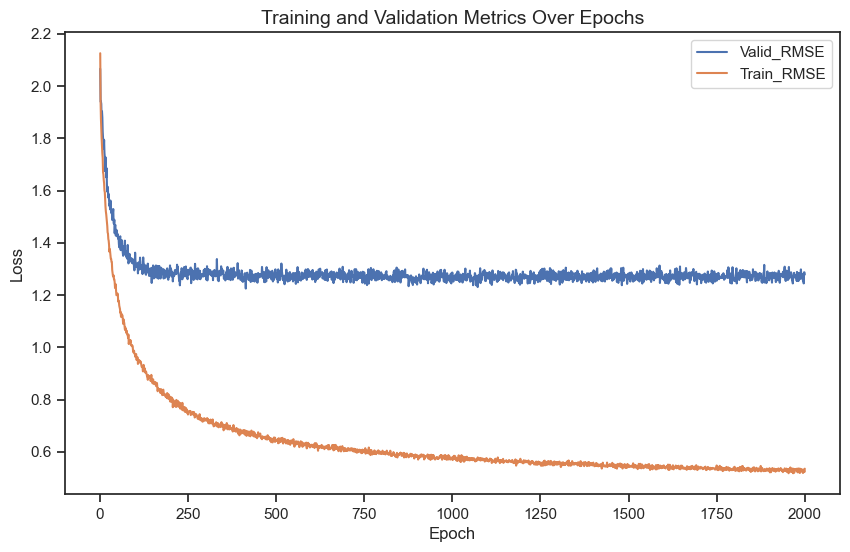

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x="epoch", y="Val MSE", label="Valid_RMSE")
sns.lineplot(data=metrics, x="epoch", y="Train MSE", label="Train_RMSE")
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title("Training and Validation Metrics Over Epochs", fontsize=14)
# Define the range of tick positions
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(False)
# Show the plot
plt.show()

In [20]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.532239,0.530403,0.504255,0.504255,0.768562,0.876681,0.340715,NaN,1.268337,0.789665,0.789665,0.461019,0.687493,0.551833,0.461424,0.768566,1.266832
1996,1997,0.531269,0.531876,0.505274,0.505274,0.767919,0.876321,0.343892,NaN,1.244448,0.780277,0.780277,0.471171,0.693046,0.539996,0.471394,0.767921,1.242618
1997,1998,0.526952,0.528187,0.503978,0.503978,0.769529,0.877230,0.342519,NaN,1.287136,0.796212,0.796212,0.453030,0.685265,0.552001,0.454375,0.769533,1.285202
1998,1999,0.522988,0.522478,0.502933,0.502933,0.772020,0.878648,0.342291,NaN,1.286750,0.796023,0.796023,0.453194,0.684276,0.561874,0.453452,0.772022,1.284602
1999,2000,0.534263,0.535272,0.507996,0.507996,0.766437,0.875466,0.347388,NaN,1.278370,0.797291,0.797291,0.456755,0.686443,0.562590,0.457824,0.766438,1.277037


In [ ]:
import torch
import numpy as np
import random
import os
import joblib

# Set random seed for reproducibility
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_predictions(model, loader, config, device):
    """
    Get predictions from the diffusion model
    """
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            mol_features = batch["metabolite_features"].to(device)
            protein_features = batch["protein_features"].to(device)
            labels = batch["label"].cpu().numpy()

            # Add noise to the features (same as training)
            noisy_mol_features = model.add_noise(mol_features, noise_level=config["noise_level"])
            noisy_protein_features = model.add_noise(protein_features, noise_level=config["noise_level"])

            # Generate predictions
            predictions = model(
                noisy_mol_features,
                noisy_protein_features,
                torch.randint(0, config["num_timesteps"], (mol_features.size(0),)).to(device),
            )
            
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels)
    
    return np.array(all_predictions), np.array(all_labels)

# Set random seed
set_random_seed(42)

# Define model configuration (same as training)
config = {
    "noise_level": 0.1,
    "num_timesteps": 10,  # Same as training (num_timesteps = 10)
    "hidden_dim": 512,
    "mol_input_dim": mol_input_dim,
    "protein_input_dim": protein_input_dim
}

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "./../../trained_model/random_split/Diffusion model.pt"

# Initialize model with same parameters as training
set_random_seed(42)

model = DiffusionGenerativeModel(
    mol_input_dim=mol_input_dim,
    protein_input_dim=protein_input_dim,
    hidden_dim=512,
    num_timesteps=10,  # Same as training
)

# Load model weights
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Get predictions for total dataset
predictions, labels = get_predictions(model, total_loader, config, device)

# Add predictions to your DataFrame
if os.path.exists('data_with_pred.joblib'):
    data_with_pred = joblib.load('data_with_pred.joblib')
else:
    data_with_pred = data.copy()

data_with_pred['Diffusion_pred'] = predictions
joblib.dump(data_with_pred, 'data_with_pred.joblib')

print(f"Total dataset predictions completed. Shape: {predictions.shape}")
print(f"Sample predictions: {predictions[:5]}")
data_with_pred

C:\Users\youbowei0126\AppData\Local\Temp\ipykernel_8128\522745196.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locat

Total dataset predictions completed. Shape: (17010,)
Sample predictions: [-0.5923373 -0.4118797 -0.9479051  1.100133   1.5082369]


,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd,metabolite_features,protein_features,...,CAT_pred,CNN_pred,GBM_pred,LR_pred,MLP_pred,RF_pred,SVR_pred,TRANS_pred,XBG_pred,Diffusion_pred
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12646541, -0.15512069, 0.0834027, 0.213126...",...,-0.664597,-1.227315,-0.456274,0.046098,-0.033697,-0.663813,-0.673010,-0.179763,-0.825415,-0.592337
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509,"[0.4610253, 0.039623156, -0.4662559, 0.4188257...","[-0.10084063, -0.099633686, -0.011382125, 0.10...",...,-0.298970,-0.735445,-0.562968,-0.532851,-0.595165,-0.703961,-0.580186,-0.836762,-0.633082,-0.411880
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12705962, -0.09898393, 0.0041820942, 0.096...",...,-0.836997,-1.242703,-0.699874,-0.381774,-0.972310,-1.196758,-0.705667,-1.218392,-0.867747,-0.947905
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939,"[0.52348095, -0.18665986, -0.39555183, 0.11716...","[0.0015065962, -0.087554656, -0.014490904, -0....",...,1.427049,0.659172,0.767883,0.932206,1.383574,0.971980,0.942095,1.131406,1.205323,1.100133
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935,"[0.17630623, -0.4595529, -0.6368343, -0.136045...","[0.0015065962, -0.087554656, -0.014490904, -0....",...,0.783579,1.170299,0.016693,0.681809,1.515772,1.115315,0.677234,1.417521,1.013881,1.508237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,1.1.1.82,Zea mays,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,955.0000,s^(-1),2.980003,"[0.36284313, -0.21340896, -0.8913718, -0.23485...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",...,-1.987372,-2.852437,-1.338873,-1.303237,-2.799196,-2.386986,-1.271998,-3.045460,-1.665534,-2.681252
17006,1.1.1.82,Zea mays,C(C(C(=O)O)O)C(=O)O,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",...,-1.656514,-1.883750,-1.248562,-1.116988,-2.273174,-1.641825,-1.042858,-0.846384,-1.593849,-0.649600
17007,1.1.1.82,Zea mays,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.18913552, -0.06542938, -0.8761325, 0.133454...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",...,-1.541640,-0.925752,-1.236483,-1.220809,-0.321132,-0.831630,-1.006784,-0.464352,-1.597621,-0.617474
17008,1.1.1.82,Spinacia oleracea,C(C(C(=O)O)O)C(=O)O,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,6.7000,s^(-1),0.826075,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.029217303, -0.08372673, 0.0883128, 0.147737...",...,-0.926702,-1.843686,-1.031461,-0.986014,-0.721271,-1.044259,-1.028191,-0.905862,-1.314823,-0.990068


: 